In [1]:
# univariate cnn lstm example
import numpy as np
import pandas as pd
from numpy import array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.layers import Conv1D
from tensorflow.layers import MaxPooling1D
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [4]:
# Dada una secuencia de Entrada
data= pd.read_excel('eurusd_10min.xlsx')

In [5]:
data.columns

Index(['<OPEN>', '<HIGH>', '<LOW>', '<TICKVOL>', '<VOL>', '<SPREAD>', 'obv',
       'obv_ema21', 'ASY1', 'ASY2', 'ASY3', 'ASY4', 'ASY5'],
      dtype='object')

In [10]:
data['Max']=data['<HIGH>']

In [11]:
raw_seq= pd.Series((data['Max'] - data['Max'].mean())/ (data['Max'].max() - data['Max'].min())).values
raw_seq=raw_seq[1:]-raw_seq[:-1]

In [12]:
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
n_features = 1

In [13]:
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
X_train=X[0:-1000]
y_train=y[0:-1000]
X_test=X[-1000:]
y_test=y[-1000:]

In [14]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [15]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='sigmoid', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

W1013 13:50:46.106137  4020 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
model.fit(X_train, y_train, epochs=1000, verbose=0)

W1013 13:50:46.631761  4020 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
y_trout = model.predict(X_train, verbose=0)

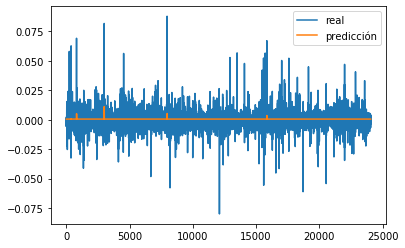

In [18]:
fig, ax = plt.subplots()
ax.plot(y_train[:,1], label='real')
ax.plot(y_trout[:,1],label='predicción')
ax.legend()
plt.show()

In [19]:
N=[]
vp=[]
vn=[]
fp=[]
fn=[]
for t in range (0,np.shape(y_trout[:,1])[0]-1):
    if ((np.sign([y_train[t+1,1][0]-y_train[t,1][0]])*np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]))>0 )& (np.sign([y_trout[t+1,1][0]-y_train[t,1][0]])>0) :
        vp.append(1)
        N.append(1)
    elif ((np.sign([y_train[t+1,1][0]-y_train[t,1][0]])*np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]))>0 )& (np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]) <0):
        vn.append(1)
        N.append(1)
    elif ((np.sign([y_train[t+1,1][0]-y_train[t,1][0]])*np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]))<0 )& (np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]) <0):
        fn.append(1)
        N.append(1)
    elif ((np.sign([y_train[t+1,1][0]-y_train[t,1][0]])*np.sign([y_trout[t+1,1][0]-y_train[t,1][0]]))<0 )& (np.sign([y_trout[t+1,1][0]-y_train[t,1][0]])> 0):
        fp.append(1)
        N.append(1)
MDA=1/sum(N)*(sum(vp)+sum(vn))
recall_1= sum(vp)/(sum(vp)+sum(fn))
recall_2= sum(vn)/(sum(vn)+sum(fp))
MDA
print('MDA: '+str(MDA),'Recall tipo 1:'+str(recall_1), 'Recall tipo 2: '+str(recall_2))

MDA: 0.7079149933065595 Recall tipo 1:0.8254400136042853 Recall tipo 2: 0.5940871283867248


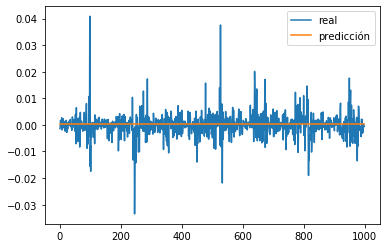

In [20]:
# testeo
y_tout = model.predict(X_test, verbose=0)
np.shape(y_test[:,1])

fig, ax = plt.subplots()
ax.plot(y_test[:,1], label='real')
ax.plot(y_tout[:,1],label='predicción')
ax.legend()
plt.show()

In [22]:
N=[]
vp=[]
vn=[]
fp=[]
fn=[]
for t in range (0,np.shape(y_tout[:,1])[0]-1):
    if ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))>0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]])>0) :
        vp.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))>0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]) <0):
        vn.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))<0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]) <0):
        fn.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))<0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]])> 0):
        fp.append(1)
        N.append(1)
MDA=1/sum(N)*(sum(vp)+sum(vn))
recall_1= sum(vp)/(sum(vp)+sum(fn))
recall_2= sum(vn)/(sum(vn)+sum(fp))
MDA
print('MDA: '+str(MDA),'Recall tipo 1:'+str(recall_1), 'Recall tipo 2: '+str(recall_2))

MDA: 0.7164480322906156 Recall tipo 1:0.8260869565217391 Recall tipo 2: 0.6122047244094488


In [34]:
y_tout.mean()

0.0005264263

In [28]:
N=[]
vp=[]
vn=[]
fp=[]
fn=[]
for t in range (0,np.shape(y_tout[:,1])[0]-1):
    if ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))>0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]])>0) & (abs(y_tout[t+1,1][0])>abs(y_tout.mean()*3)):
        vp.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))>0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]) <0) & (abs(y_tout[t+1,1][0])>abs(y_tout.mean()*3)):
        vn.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))<0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]) <0) & (abs(y_tout[t+1,1][0])>abs(y_tout.mean()*3)) :
        fn.append(1)
        N.append(1)
    elif ((np.sign([y_test[t+1,1][0]-y_test[t,1][0]])*np.sign([y_tout[t+1,1][0]-y_test[t,1][0]]))<0 )& (np.sign([y_tout[t+1,1][0]-y_test[t,1][0]])> 0)& (abs(y_tout[t+1,1][0])>abs(y_tout.mean()*3) ):
        fp.append(1)
        N.append(1)
MDA=1/sum(N)*(sum(vp)+sum(vn))
recall_1= sum(vp)/(sum(vp)+sum(fn))
recall_2= sum(vn)/(sum(vn)+sum(fp))
MDA
print('MDA: '+str(MDA),'Recall tipo 1:'+str(recall_1), 'Recall tipo 2: '+str(recall_2))

ZeroDivisionError: division by zero

In [29]:
vn

[]

In [30]:
fp

[]

In [31]:
vp

[]

In [32]:
fn

[]

In [33]:
N

[]